In [1]:
from geodude.line import bezier_func, dash_linestring
from geodude.utils import Paper, merge_LineStrings
import vsketch
import numpy as np
from shapely.geometry import (
    box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString)
from pathlib import Path

%load_ext autoreload
%autoreload 2


In [2]:

def generate_interpolation_dists(dist_gen):
    max_value = 0
    values = []
    while max_value < 1:
        delta = dist_gen.rvs()
        dist = max_value + delta
        if dist > 1:
            break
        values.append(dist)
        max_value = dist
    return np.array(values)

# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)


In [29]:

n_lines = 70
xmin, ymin, xmax, ymax = drawbox.bounds
width = xmax - xmin
top_xmin = xmin + width * 0.3
top_xmax = xmax - width * 0.3
bottom_xmin = xmin + width * 0.1
bottom_xmax = xmax - width * 0.1
line_top_xs = np.linspace(top_xmin, top_xmax, n_lines)
line_top_ys = np.ones(n_lines) * ymax
line_top_pts = list(zip(line_top_xs, line_top_ys))


In [36]:

def get_ctrl_pts(x, y):
    ctrl_pt_xs = [
        x,
        x,
        x,
        np.interp(x, [top_xmin, top_xmax], [xmin, xmax]),
        np.interp(x, [top_xmin, top_xmax], [xmax, xmin]),
        np.interp(x, [top_xmin, top_xmax], [xmin, xmax]),
        np.interp(x, [top_xmin, top_xmax], [xmin, xmax]),
        np.interp(x, [top_xmin, top_xmax], [xmin, xmax]),
        np.interp(x, [top_xmin, top_xmax], [bottom_xmin, bottom_xmax]),
        np.interp(x, [top_xmin, top_xmax], [bottom_xmin, bottom_xmax]),
    ]
    ctrl_pt_ys = np.linspace(ymin, ymax, len(ctrl_pt_xs))
    return list(zip(ctrl_pt_xs, ctrl_pt_ys))

ctrl_pt_sets = [get_ctrl_pts(x,y) for x,y in line_top_pts]
bezier_funcs = [bezier_func(ctrl_pts) for ctrl_pts in ctrl_pt_sets]
n_eval_pts = 200
eval_pts = np.linspace(0,1,n_eval_pts)
lines = [bezier_func(eval_pts) for bezier_func in bezier_funcs]

mls = MultiLineString(lines)
bottom_circle = Point((xmax+xmin)/2, (ymax+ymin)/2).buffer(100)
inside_circle = mls.intersection(bottom_circle)
outside_circle = mls.difference(bottom_circle)

base_breakpoints =  np.geomspace(0.001, 1,300)
breakpoint_sets = [np.sort(np.random.choice(base_breakpoints, size=130, replace=False)) for _ in range(n_lines)]
dashed_lines = [dash_linestring(ls, breakpoints) for ls, breakpoints in zip(inside_circle.geoms, breakpoint_sets)]


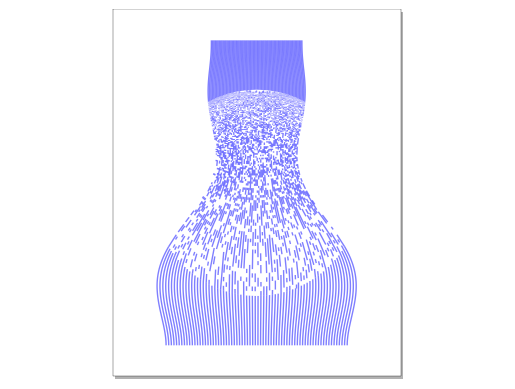

In [37]:

dashed_mls = merge_LineStrings(dashed_lines)
all_mls = merge_LineStrings([outside_circle, dashed_mls])

sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.05mm')

sk.geometry(all_mls)
sk.display()


In [38]:

sk.vpype('splitall linemerge linesort')

plot_id = '20230307_dashed_prototype2'

savedir = 'outputs'
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)